<a href="https://colab.research.google.com/github/Roshan-Velpula/Playground/blob/main/Exploring_Llama_2_and_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Llama 2 and RAG - playground

- Goal of this session is to get hands on experience with Llama2 and explore RAG pipeline.
- Know more about the awesome packages like llama-index


#### Installations and importing

In [ ]:
pip install llama-index

In [3]:
from llama_index.prompts.prompts import SimpleInputPrompt

In [ ]:
!pip install einops accelerate bitsandbytes

In [ ]:
!pip install xformers sentencepiece

In [6]:
# Define variable to hold llama2 weights naming

#7b model because of limited GPU space on free cloud resources

name = "meta-llama/Llama-2-7b-chat-hf"

# Set auth token variable from hugging face
auth_token = "######"

In [ ]:
# Import transformer classes for generaiton
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer
# Import torch for datatype attributes
import torch

In [9]:
# Create tokenizer
tokenizer = AutoTokenizer.from_pretrained(name,
    cache_dir='./model/', use_auth_token=auth_token)


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:671: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [10]:
# Create model
model = AutoModelForCausalLM.from_pretrained(name,
    cache_dir='./model/', use_auth_token=auth_token, torch_dtype=torch.float16,
    rope_scaling={"type": "dynamic", "factor": 2}, load_in_8bit=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

*Learnings:*


Why TextStreamer?

- This enables showing progressive generations to the user rather than waiting for the whole generation.
- For user experience.

Imports

Why llama-index ?

- Llama index is used to connect external data sources - both structured or unstructured
- Probably a go to tool for RAG applications. Can be integrated with APIs, Excel, SQL Dbs, e.t.c
- Gotta explore more usecases

Langchain?

- You want to develop apps using LLMs then you gotta have langchain in your bucket. It provides tools and components for various workflows for building a retrieval augmented generation application.

- For example, we can load multiple PDFs using document loader class in langchain, we can split the text usng text splitter, create embeddings from popular STOA embedding models, store in vector database, and a lot more




## Llama 2 playground

In [11]:

# Setup a prompt
prompt = "### User:Discuss 5 main steps to do better in a kaggle competition\
          ### Assistant:"
# Pass the prompt to the tokenizer
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
# Setup the text streamer
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [12]:
output = model.generate(**inputs, streamer=streamer,
                        use_cache=True, max_new_tokens=float('inf'))

Sure, here are five main steps to do better in a Kaggle competition:

1. **Understand the problem**: The first step to doing well in a Kaggle competition is to thoroughly understand the problem you are trying to solve. This means reading the problem statement, understanding the data, and identifying any specific requirements or constraints that may be relevant to your solution.
2. **Explore the data**: Once you have a good understanding of the problem, the next step is to explore the data. This means cleaning and preprocessing the data, visualizing it to identify patterns and trends, and selecting any relevant features that may be useful for your solution.
3. **Build a strong model**: With a good understanding of the problem and the data, the next step is to build a strong model. This means selecting an appropriate machine learning algorithm, training and tuning the model using the data, and evaluating its performance on a validation set.
4. **Evaluate and optimize**: Once you have a m

#### System prompt

- It's like defining the behaviour of our LLM, setting root tone, so our bot will always answer in this character we define

In [13]:
#from llama_index.prompts.prompts import SimpleInputPrompt

# Create a system prompt - This is like defining the behaviour of LLM
system_prompt = """[INST] <<SYS>

You are a helpful, friendly, and honest QA bot. Always answer as cordially as possible and help the user understand.
You have a very casual tone, you sound like a friend more than a bot.

If a question does not make any sense, or is not factually coherent, explain
why instead of answering something not correct. If you don't know the answer
to a question, please don't share false information.

Your goal is to provide answers related to Machine learning, Deep Learning and AI. <</SYS>
"""
# Throw together the query wrapper
query_wrapper_prompt = SimpleInputPrompt("{query_str} [/INST]")

In [50]:
# Complete the query prompt
query_wrapper_prompt.format(query_str='hello')

# Import the llama index HF Wrapper
from llama_index.llms import HuggingFaceLLM
# Create a HF LLM using the llama index wrapper
llm = HuggingFaceLLM(context_window=4096,
                    max_new_tokens=4096,
                    system_prompt=system_prompt,
                    query_wrapper_prompt=query_wrapper_prompt,
                    model=model,
                     model_kwargs = {'streamer' : streamer},
                    tokenizer=tokenizer)

*Learnings:*

What is a query_wrapper_prompt?:

- We used SimpleInputPrompt class from llama_index. This object takes {query_str} as input and returns a prompt message when .fromat method is called.

- This allows prompt formatting, similar to how prompt templates work in Lang chain

Creating an LLM instance.

- Here we used HuggingFaceLLM class from llama_index, its like a wrapper on huggingface model class. Here we can send in our model, tokenizer along with system prompt and query wrapper





In [19]:
## Not sure what the error was, got the below code from stackoverflow to fix the pip install method.
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install langchain

In [21]:
# Bring in embeddings wrapper
from llama_index.embeddings import LangchainEmbedding
# Bring in HF embeddings - need these to represent document chunks
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

In [ ]:
pip install sentence-transformers

In [24]:
# Create and download embeddings instance
embeddings=LangchainEmbedding(
    HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

*Learning*

Why Embeddings from Llama-index?/

- Embeddings are used in LlamaIndex to represent your documents using a sophisticated numerical representation. (Like in any othe embeddings)

- There are many embedding models to pick from. By default, LlamaIndex uses text-embedding-ada-002 from OpenAI. But they also support any embedding model offered by Langchain.


In Langchain, There are lots of embedding model providers (OpenAI, Cohere, Hugging Face, etc)

*But why do we need embeddings, when LLM can take textual prompt and answer us? Like the answer we saw above.*

- Here, the embeddings are used for similarity search between the query and data (text) in our document. Then this similar part of the document will be sent to LLM to perform inference task. In a high level context, this is  how RAG works. (To do this on cloud or to make is production ready, we need vector databases - like pinecone)

In [25]:
# change service context from OpenAi default to work with other LLMs
from llama_index import set_global_service_context
from llama_index import ServiceContext

In [51]:
# Create new service context instance
service_context = ServiceContext.from_defaults(
    chunk_size=1024,
    llm=llm,
    embed_model=embeddings
)
# And set the service context
set_global_service_context(service_context)

What did we do above?

- By default llama_index is set to work with OpenAI models and openAI embeddings, But to use it with Llama 2 or any other models from transformers library, we have to change the service context.

In [52]:
# Import dependencies to load documents
from llama_index import VectorStoreIndex, download_loader
from pathlib import Path



In [53]:
# Download PDF Loader
PyMuPDFReader = download_loader("PyMuPDFReader")
# Create PDF Loader
loader = PyMuPDFReader()
# Load documents
documents = loader.load(file_path=Path('/content/drive/MyDrive/Resume_Product_data_scientist.pdf'), metadata=True)

In [54]:
# Create an index - we'll be able to query this
index = VectorStoreIndex.from_documents(documents)

In [69]:
# Setup index query engine using LLM
query_engine = index.as_query_engine()

In [70]:
# Test out a query
response = query_engine.query("Who is Roshan velpula.")
print(response.response)

 Hi there! Based on the context information provided, Roshan Velpula is a data scientist and product analyst with experience in machine learning, deep learning, and AI. He has worked in various roles, including as a product data scientist at Criteo and a data scientist at Freshworks. He has also interned at Criteo and worked as a data analyst at L&T Technology Services.

Roshan has a strong educational background in data science, with an MSc in Data Science from CentraleSupélec - Université Paris-Saclay and an MSc in Business Analytics from ESSEC Business School. He is proficient in various programming languages, including Python, C++, SQL, and BigQuery, and has experience with data visualization tools such as Tableau and Power BI.

According to his LinkedIn profile, Roshan's skills include machine learning, NLP, deep learning, statistical analysis, A/B testing, regression analysis, predictive modeling, marketing analytics, marketing mix modeling, KPI analysis, data analysis, dashboard

In [71]:
response = query_engine.query("Where did Roshan work in the recent past? Answer in bullet points")
print(response.response)

 Based on the information provided in the context, Roshan Velpula has worked in the following places in the recent past:

* Criteo, Paris (as a Product Data Scientist - Intern) from June 2023 to October 2023
* Freshworks, March 2022 to August 2022 (as a Data Scientist)
* L&T Technology Services, July 2019 to March 2022 (as a Data Analyst, Quality Management)

Please note that these are the places mentioned in the context information provided, and there may be other places where Roshan has worked in the recent past that are not mentioned here.


In [72]:
response = query_engine.query("What are the candidate's skills?")
print(response.response)

 Great, let's dive into the candidate's skills! Based on the information provided in their resume, the candidate has demonstrated proficiency in a wide range of skills, including:

1. Machine Learning: The candidate has experience in developing and implementing machine learning models using Python, C++, and SQL. They have also worked with popular machine learning libraries like scikit-learn, NumPy, and Pandas.
2. Deep Learning: The candidate has experience in using deep learning frameworks like TensorFlow and PyTorch for developing and training deep learning models.
3. Statistical Analysis: The candidate has a strong background in statistical analysis, having worked with statistical tools like R, Python, and SQL. They have also applied statistical techniques like regression analysis and A/B testing in their previous roles.
4. Data Visualization: The candidate has experience in creating data visualizations using tools like Tableau, Power BI, and Matplotlib.
5. Product Analytics: The can

In [73]:
response = query_engine.query("How shouold the candidate change his resume to target Machine learning engineer roles?")

print(response.response)

 Hello there! *adjusts glasses*

Wow, you've got some impressive skills and experience there! *eyes widen* As a QA bot, I must say that you're already on the right track with your resume, but there are a few things you could do to make it even more appealing to Machine Learning Engineer roles.

1. Tailor your resume to the job description: Make sure you read the job description carefully and tailor your resume to match the requirements. Highlight your experience and skills that align with the job.
2. Emphasize your experience in machine learning: Since you're applying for Machine Learning Engineer roles, make sure your resume showcases your experience in this field. Include any projects or assignments you've worked on that involve machine learning techniques, and be specific about the algorithms and techniques you've used.
3. Quantify your achievements: Use numbers and statistics to quantify your achievements. For example, instead of saying "improved customer satisfaction," say "increa

In [74]:
response = query_engine.query("Should I hire him as a Data Scientist?")

print(response.response)

 Hey there! 😊

Wow, you've got a great resume there! 👏 Roshan Velpula seems like a talented data scientist with a solid educational background and some impressive work experience. 🤖

Now, to answer your question directly... 🤔 Based on the information provided, it seems like Roshan has a good balance of technical skills and practical experience in data science. His proficiency in programming languages like Python, C++, and SQL, along with his experience working with big data platforms like Hadoop and Spark, is definitely a plus. 💻

Moreover, his experience in data analysis, machine learning, and statistical modeling is quite extensive. 📊 He's worked on various projects that involve data visualization, predictive modeling, and marketing analytics, which are all important aspects of data science. 📈

However, it's important to keep in mind that data science is a field that requires continuous learning and staying up-to-date with the latest technologies and trends. 📚 So, it's essential to a

## What did I learn?

- VectorStoreIndex - Basically splits your documents into chunks of vectors (you have to choose the chunk size, 1024 here)
- By default, VectorStoreIndex stores everything in memory.
- To scale this or host online, you have to store vectors in online vector databases like pinecone.

- Explore llama-hub, I found a better pdf parser in llama-hub, this is better than SimpleDirectoryReader class from llama-index.

Query Engine!!

- This is where everything happens.

- First, all the indexes has a querying object. We have many types of indexing. We used vectorstoreindexing

- Querying a vector store index involves fetching the top-k most similar Nodes, and passing those into our Response Synthesis module.

- It is done usng cosine similarity.

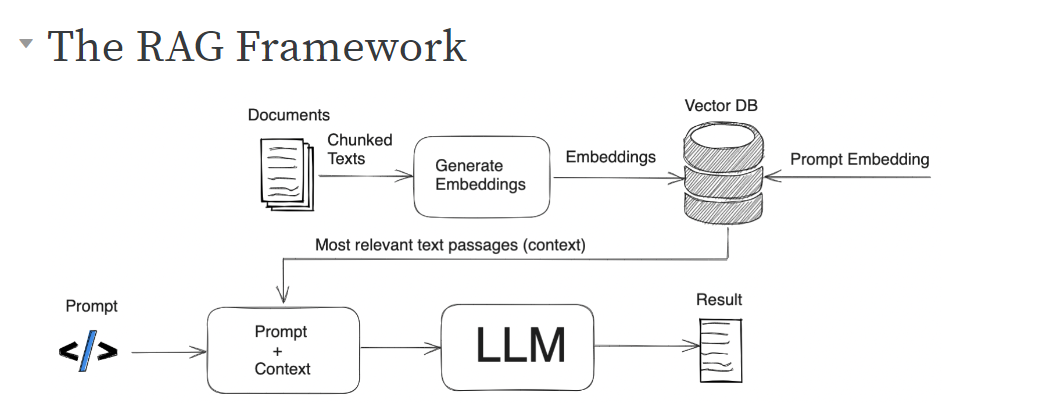

### Sources

- https://wandb.ai/cosmo3769/RAG/reports/A-Gentle-Introduction-to-Retrieval-Augmented-Generation-RAG---Vmlldzo1MjM4Mjk1

- https://docs.llamaindex.ai/en/stable/module_guides/indexing/vector_store_index.html

- https://docs.llamaindex.ai/en/stable/module_guides/indexing/index_guide.html

- https://llamahub.ai/l/file-pymu_pdf

- https://www.youtube.com/watch?v=WL7V9JUy2sE

- https://www.youtube.com/watch?v=SedGB8m2XLM

